<a href="https://colab.research.google.com/github/hrishi508/Self-and-Semi-Supervised-Learning/blob/main/Barlow_Twins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchviz import make_dot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


## Getting Data from ```torchvision```

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),    
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),   
    
])

training_data = datasets.STL10(
    root="data",
    split="train",
    transform=transform,
    download=False
)

test_data = datasets.STL10(
    root="data",
    split='test',
    transform=transform,
    download=False
)

unlabeled = datasets.STL10(
    root="data",
    split="unlabeled",
    transform=transform,
    download=False
)

In [ ]:
def imshow(imgt):
    img = imgt.clone()
    t1 = torch.tensor([0.485, 0.456, 0.406])
    t2 = torch.tensor([0.229, 0.224, 0.225])
    img[0]*=t2[0]
    img[1]*=t2[1]
    img[2]*=t2[2]

    img[0]+=t1[0]
    img[1]+=t1[1]
    img[2]+=t1[2]

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

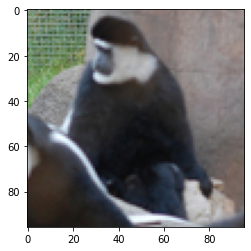

monkey
torch.Size([3, 96, 96])


In [ ]:
labels_map = {
    0: "airplane",
    1: "bird",
    2: "car",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "horse",
    7: "monkey",
    8: "ship",
    9: "truck",
}
img, label = training_data[155]
imshow(img)
print(labels_map[label])
print(img.shape)

## Preparing the dataset using ```DataLoader```

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
## HYPERPARAMETERS
BATCH_SIZE = 256  #64
LR = 0.00001      #0.001
EPOCHS = 100

In [ ]:
train_dataloader = DataLoader(unlabeled, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
print(train_dataloader.dataset)

Dataset STL10
    Number of datapoints: 100000
    Root location: data
    Split: unlabeled
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


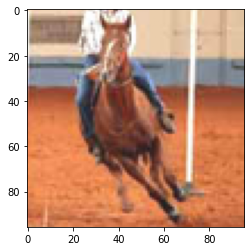

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0]
imshow(img)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
import time
import copy

In [ ]:
def augment(x):
    # t = transforms.RandomApply([
    #     transforms.RandomHorizontalFlip(0.5),
    #     # transforms.RandomRotation(15),
    #     transforms.GaussianBlur(9, sigma=(0.1, 2.0)),
    #     transforms.RandomSolarize(0.5, 0.2),
    #     transforms.ColorJitter(0.4, 0.4, 0.2, 0.1) 
    # ], p=0.7)

    # im1 = t(x)
    # im2 = t(x)

    # return im1, im2
    return x.clone(), x.clone()


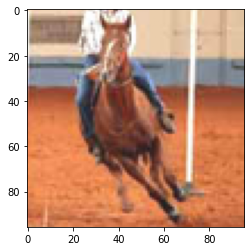

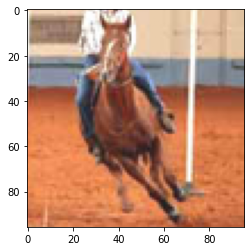

In [ ]:
a, b = augment(img)
imshow(a)
imshow(b)

In [ ]:
def train_model(model, dataloader, criterion, optimizer, lambd, num_epochs=100):
    since = time.time()
    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train()  # Set model to training mode

        running_loss = 0.0

            # Iterate over data.
        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            ix1, ix2 = augment(inputs)                     
            x1 = torch.squeeze(model(ix1))
            x2 = torch.squeeze(model(ix2))
            print(x1-x2)

            
            x1 = (x1 - torch.std_mean(x1, 0)[1])/(torch.std_mean(x1, 0)[0] + 1e-9)
            x2 = (x2 - torch.std_mean(x2, 0)[1])/(torch.std_mean(x2, 0)[0] + 1e-9)
            
            C = torch.matmul(x1.T, x2)/len(inputs)
            print(C)
            # print(C.shape)
            
            loss = criterion(C, lambd)
            # make_dot(loss, params=dict(list(model_ft.named_parameters()))).render("model_torchviz", format="png")
            # break

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)

            print('Loss: {:.4f}'.format(epoch_loss))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

In [ ]:
a = torch.tensor([[3,3,3],[3,3,3]]) / torch.tensor([3,3,3])
a

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [ ]:
x1 = torch.ones((64,128))*30
print(x1)
print(torch.std_mean(x1, 0)[0])
x1 = (x1 - torch.std_mean(x1, 0)[1])/torch.std_mean(x1, 0)[0]
print(x1)

tensor([[30., 30., 30.,  ..., 30., 30., 30.],
        [30., 30., 30.,  ..., 30., 30., 30.],
        [30., 30., 30.,  ..., 30., 30., 30.],
        ...,
        [30., 30., 30.,  ..., 30., 30., 30.],
        [30., 30., 30.,  ..., 30., 30., 30.],
        [30., 30., 30.,  ..., 30., 30., 30.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet9, self).__init__()
        
        self.conv1 = conv_block(in_channels, 64,pool=True)
        self.conv2 = conv_block(64, 128, pool=True) # output: 128 x 24 x 24
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # output: 256 x 12 x 12
        self.conv4 = conv_block(256, 512, pool=True) # output: 512 x 6 x 6
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, 128))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model_ft = ResNet9(3, 10)
print(model_ft)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

In [ ]:
def loss_fn(C, lambd):
    loss = 0
    temp = (C - torch.eye(C.size(0), requires_grad=False).to(device))**2
    temp2 = temp * ((torch.ones(C.shape, requires_grad=False)-torch.eye(C.size(0), requires_grad=False))*lambd).to(device)
    loss = torch.sum(temp2)
    return loss

optimizer = torch.optim.Adam(params=model_ft.parameters(), lr=LR)

In [ ]:
def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

In [ ]:
def train_model_2(model, dataloader, criterion, optimizer, lambd, num_epochs=100):
    since = time.time()
    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train()  # Set model to training mode

        running_loss = 0.0

            # Iterate over data.
        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            ix1, ix2 = augment(inputs)                     
            x1 = model(ix1)
            x2 = model(ix2)
            print(x1.shape)
            print(x1-x2)

            
            
            # x1 = (x1 - torch.std_mean(x1, 0)[1])/torch.std_mean(x1, 0)[0]
            # x2 = (x2 - torch.std_mean(x2, 0)[1])/torch.std_mean(x2, 0)[0]
            
            # C = torch.matmul(x1.T, x2)/len(inputs)
            # print(C)
            # # print(C.shape)
            
            # loss = criterion(C, lambd)
            # # make_dot(loss, params=dict(list(model_ft.named_parameters()))).render("model_torchviz", format="png")
            # # break
            m = nn.BatchNorm1d(x1.size(1), affine = False)
            C = (m(x1).T @ m(x2))/len(inputs)
            on_diag = torch.diagonal(C).add_(-1).pow_(2).sum()
            off_diag = off_diagonal(C).pow_(2).sum()
            loss = on_diag + lambd * off_diag
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)

            print('Loss: {:.4f}'.format(epoch_loss))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

In [ ]:
from torch import optim
class LARS(optim.Optimizer):
    def __init__(self, params, lr, weight_decay=0, momentum=0.9, eta=0.001,
                 weight_decay_filter=False, lars_adaptation_filter=False):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum,
                        eta=eta, weight_decay_filter=weight_decay_filter,
                        lars_adaptation_filter=lars_adaptation_filter)
        super().__init__(params, defaults)


    def exclude_bias_and_norm(self, p):
        return p.ndim == 1

    @torch.no_grad()
    def step(self):
        for g in self.param_groups:
            for p in g['params']:
                dp = p.grad

                if dp is None:
                    continue

                if not g['weight_decay_filter'] or not self.exclude_bias_and_norm(p):
                    dp = dp.add(p, alpha=g['weight_decay'])

                if not g['lars_adaptation_filter'] or not self.exclude_bias_and_norm(p):
                    param_norm = torch.norm(p)
                    update_norm = torch.norm(dp)
                    one = torch.ones_like(param_norm)
                    q = torch.where(param_norm > 0.,
                                    torch.where(update_norm > 0,
                                                (g['eta'] * param_norm / update_norm), one), one)
                    dp = dp.mul(q)

                param_state = self.state[p]
                if 'mu' not in param_state:
                    param_state['mu'] = torch.zeros_like(p)
                mu = param_state['mu']
                mu.mul_(g['momentum']).add_(dp)

                p.add_(mu, alpha=-g['lr'])

In [ ]:
optimizer = LARS(model_ft.parameters(), lr=0, weight_decay=1e-6,
                     weight_decay_filter=True,
                     lars_adaptation_filter=True)

In [ ]:
train_model(model_ft, train_dataloader, loss_fn, optimizer, lambd=5*1e-3, num_epochs=1) #labmd = 5*1e-3

Epoch 0/0
----------
tensor([[ 1.9932, -0.2997, -0.7394,  ..., -0.0882, -1.2990,  0.0684],
        [ 2.2910,  2.4631, -1.0270,  ..., -2.3091, -1.4471,  1.2469],
        [ 0.4207, -0.0301,  0.2125,  ...,  0.1386, -1.6514,  2.2117],
        ...,
        [-1.3423,  2.4984,  2.9840,  ...,  2.2338,  0.5988, -0.8171],
        [-0.6809, -1.0045, -2.2156,  ...,  0.3118, -0.8955,  0.6694],
        [ 0.2905, -2.3449, -3.6661,  ..., -1.5069,  0.2599, -1.2625]],
       grad_fn=<SubBackward0>)
tensor([[ 0.2919, -0.0104,  0.2130,  ...,  0.3237, -0.1698,  0.0206],
        [-0.0278,  0.1794,  0.0517,  ...,  0.0050,  0.0051, -0.0657],
        [ 0.1417,  0.0325,  0.3996,  ...,  0.3015, -0.3562,  0.0297],
        ...,
        [ 0.2925,  0.0546,  0.3291,  ...,  0.5728, -0.3394,  0.0030],
        [-0.1581, -0.0496, -0.2655,  ..., -0.3506,  0.3019, -0.0279],
        [-0.0562,  0.0377, -0.0941,  ..., -0.0720,  0.0588,  0.1025]],
       grad_fn=<DivBackward0>)
Loss: 0.0047
tensor([[ 0.4258, -1.8342,  1.6179, 

KeyboardInterrupt: ignored

In [ ]:
# torch.save(model_ft.state_dict(), '/content/drive/MyDrive/weights_stl10.pth')

In [ ]:
a = torch.randn((256,128))
m = nn.BatchNorm1d(a.size(1), affine = False)
x = m(a)
x
a.shape


In [ ]:
x1

In [ ]:
model_ft.train()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

In [ ]:
for inputs, _ in train_dataloader:
    inputs = inputs.to(device)
    ix1, ix2 = augment(inputs)
    x1 = model_ft(ix1)
    x2 = model_ft(ix2)
    print(torch.sum(abs(x1-x2)))
    break

tensor(36867.6055, grad_fn=<SumBackward0>)
